# Tutorial 6: Regression

In [2]:
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import sys
import os
import statsmodels.api as sm
from scipy.stats import norm, t, ecdf

In [3]:
FDA_DIR = os.path.join(os.getcwd(), os.pardir, r'PycharmProjects/Financial-Data-Analytics')
DATA_DIR = rf'{FDA_DIR}/Datasets'

def read_file(filename, dir=None, static=False, **kwargs):
    if dir is None:
        dir = DATA_DIR
        
    path = os.path.join(dir, filename)
    extension = filename.rsplit('.', 1)[-1]

    if extension == 'csv':
        return pd.read_csv(path, **kwargs)
    elif extension in ['parq', 'parquet']:
        return pd.read_parquet(path, **kwargs)
    elif extension == 'json':
        with open(path, 'r') as file:
            return json.load(file)
    elif extension == 'xlsx':
        return pd.read_excel(path, **kwargs)
    else:
        raise NotImplementedError

In [4]:
def backward_elimination(mod, y, X, significance_level=0.05, verbose=True, fit_kwargs={}):
    """
    Modified from https://www.geeksforgeeks.org/machine-learning/ml-multiple-linear-regression-backward-elimination-technique/
    """
    num_vars = X.shape[1]
    for i in range(num_vars):
        # Fit model using Ordinary Least Squares (OLS)
        regressor = mod(y, X).fit(**fit_kwargs)
        if verbose:
            print(regressor.summary())

        # Get the highest p-value
        max_p_value = max(regressor.pvalues)  
        if max_p_value > significance_level:  
            # If p-value is greater than the threshold, remove that predictor
            max_p_col = regressor.pvalues.idxmax()
            X = X.drop(columns=max_p_col)
            print(f'----------STEP {i + 1}: Dropping {max_p_col} with p-value: {max_p_value:.2f}----------\n')
        else:
            # Stop when all p-values are below the significance level
            break
    return X, regressor

In [5]:
def plot_against_theo(x, theo_dist, normalize=True, theo_dist_kwargs={},
                      title='QQ Plot', norm=True, ax=None, **kwargs):
    if normalize:
        x = (x - x.mean()) / x.std()
        
    empirical_cdf = ecdf(x).cdf
    e_q, e_prob = empirical_cdf.quantiles, empirical_cdf.probabilities
    theo_q = theo_dist.ppf(e_prob, **theo_dist_kwargs)

    if ax is None:
        plt.figure(**kwargs)
        ax = plt.gca()

    ax.set_title(title)
    ax.scatter(theo_q, e_q, s=5)
    ax.set_xlabel('theoretical')
    ax.set_ylabel('empirical')
    ax.plot(theo_q, theo_q, linestyle='--', color='r')

## 1. Linear Regression

## 1.1 Theory

The two objectives of regression analysis are prediction and inference:
1. Prediction: Predicting values of one or more  response (dependent) variables from a collection of predictor (independent)
2. Inference: Assessing the effects of the predictor variables on the responses.

#### 1.1.1 Assumptions

The ordinary linear regression has its limitations and can be easily abused; indeed, recall that regression has the following assumptions:

1. The regression function of $y$ is a linear function in the independent variables $x$'s, i.e.,
	$$\mathbb{E}(y|x)=\beta_0+\beta_1 x_1 +\ldots+ \beta_p x_p.$$
2. The idiosyncratic noises $\varepsilon_i$'s are independently and identically distributed as $N(0, \sigma^2)$ (or just as a time series of martingale differences).
3. The error variance $\sigma^2$ is constant.


#### 1.1.2 Model

Let $x_1, x_2, \cdots, x_p$ be $p$ predictor variables that are thought to be related to a response variable $y$. The linear regression model assumes the following form of $y$:
\begin{equation*}
	y_i = \beta_0 + \beta_1 x_{i1} + \cdots + \beta_p x_{ip} + \varepsilon_i \, , \qquad \varepsilon_i \overset{i.i.d.}{\sim} \mathcal{N}(0, \sigma^2) \, .
\end{equation*}
The $\varepsilon_i $'s are called the random noise term where $\varepsilon_i \perp\!\!\!\!\perp \epsilon_k$ for $i \neq k$ and $\beta_j$'s are called the regression coefficients. In matrix form, this model is written as:
\begin{equation*}
	\mathbf y = \left(\begin{array}{c}
		y_1	\\	y_2	\\	\vdots	\\	y_n
	\end{array}\right) = 
	\left(\begin{array}{cccc}
		1	&	x_{11}	&	\cdots	&	x_{1p}	\\
		1	&	x_{21}	&	\cdots	&	x_{2p}	\\
		\vdots	&	\vdots	&	\ddots	&	\vdots	\\
		1	&	x_{n1}	&	\cdots	&	x_{np}
	\end{array}\right)
	\left(\begin{array}{c}
		\beta_0	\\	\beta_1	\\	\vdots	\\	\beta_p
	\end{array}\right) + 
	\left(\begin{array}{c}
		\varepsilon_1	\\	\varepsilon_2	\\	\vdots	\\	\varepsilon_n
	\end{array}\right) = \tilde{\mathbf X} \mathbf \beta + \mathbf \varepsilon \, ,
\end{equation*}
where $\tilde{\mathbf X}:= (\mathbf 1, \mathbf X)$ is the augmented data matrix with a column of 1. 

#### 1.1.3 Estimating $\beta$

$\tilde{\mathbf X}$ is full rank (linearly independent feature variables), then it is straightforward to prove that the least squares estimator of $\mathbf \beta$ is given by
\begin{equation*}
	\hat{\mathbf \beta} = (\tilde{\mathbf X}^\top \tilde{\mathbf X})^{-1} \tilde{\mathbf X}^\top \mathbf y \, ,
\end{equation*}
which can be easily shown as: $\mathbf \varepsilon = \mathbf y - \tilde{\mathbf X} \mathbf \beta$, then
\begin{align*}
	\nabla_{\mathbf \beta} \mathbf \varepsilon^\top \mathbf \varepsilon &= \nabla_{\mathbf \beta} (\mathbf y - \tilde{\mathbf X} \mathbf \beta)^\top (\mathbf y - \tilde{\mathbf X} \mathbf \beta) = \nabla_{\mathbf \beta} \Big(\mathbf y^\top \mathbf y - \mathbf y^\top \tilde{\mathbf X} \mathbf \beta - \mathbf \beta^\top \tilde{\mathbf X}^\top \mathbf y + \mathbf \beta^\top \tilde{\mathbf X}^\top \tilde{\mathbf X} \mathbf \beta\Big) \\
	&= -\tilde{\mathbf X}^\top \mathbf y - \tilde{\mathbf X}^\top \mathbf y + 2 \tilde{\mathbf X}^\top \tilde{\mathbf X} \mathbf \beta \, .
\end{align*}
Setting the above equation to zero yields the above least square estimate $\hat{\mathbf \beta}$.

### 1.2 Misuse of Linear Regression

For any machine learning task, a data scientist's job is not just about blindly fitting models, but also digging into the features and models' goodness of fit. 

First, not all of the given variables will be a good explanatory component, feature selection is an important procedure.

A common used method in traditional regression task is called backward elimination, which is based on t-test for the coefficients.

#### 1.2.1 Demo

The csv file fin-ratio.csv contains financial ratios of 680 securities listed on the HKEX in 2002. 

There are six financial variables: Earnings yield, cash flow to price, logarithm of market value, dividend yield, book to market equity, and debt to equity. 

Among these companies, there are 32 blue chips which are the Hang Seng index constituent stocks. 

The last column HIS is a binary variable indicating whether a stock is a blue chip or not.

Suppose we have no information on the rules of being a blue chip stock, so we want to back it out with statistical methods.

<b>Pay attentions to how t-test is conducted, what is $R^2$ (coefficient of determinant), what is adjusted $\bar{R}^2$</b>

In [19]:
# Read Data
df = read_file('fin-ratio.csv')
df

,EY,CFTP,ln_MV,DY,BTME,DTE,HSI
0,-1.8292,-0.1732,5.5405,0.000,1.0379,0.2466,0
1,-0.0797,-0.0830,6.8272,0.000,0.1275,25.4606,0
2,-2.2360,-0.6897,5.0102,0.000,-0.2959,3.3263,0
3,-1.5406,-4.1667,4.4954,0.000,-2.8571,0.9148,0
4,-0.9006,-0.3872,4.5031,0.000,2.7981,0.0753,0
...,...,...,...,...,...,...,...
675,0.0772,0.0327,7.9266,4.878,0.3303,0.3948,0
676,0.1447,0.2947,6.9895,3.774,1.6247,0.5565,0
677,0.0394,0.0324,6.9378,1.270,0.8139,0.6896,0
678,0.1153,0.1958,5.7867,0.000,2.9244,0.2420,0


In [20]:
# Feature Processing 
df2 = sm.add_constant(df)
y = df2['HSI']
X = df2.drop(columns='HSI')

# Fit a Linear Regression
mod = sm.OLS(y, X).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    HSI   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     66.09
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           1.58e-64
Time:                        23:10:06   Log-Likelihood:                 248.18
No. Observations:                 680   AIC:                            -482.4
Df Residuals:                     673   BIC:                            -450.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4591      0.027    -17.112      0.000      -0.512      -0.406
EY            -0.0017      0.002     -1.061      0.289      -0.005       0.001
CFTP          -0.0104      0.004     -2.781      0.006      -0.018      -0.003
ln_MV          0.0810      0.004     19.818      0.000       0.073       0.089
DY            -0.0027      0.002     -1.534      0.126      -0.006       0.001
BTME           0.0005      0.001      0.604      0.546      -0.001       0.002
DTE            0.0011      0.002      0.588      0.557      -0.002       0.005
==============================================================================
Omnibus:                      304.029   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1532.164
Skew:                           2.002   Prob(JB):                         0.00
Kurtosis:                       9.168   Cond. No.                         37.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# Perform Backward Elimination
X_optimized, final_model = backward_elimination(sm.OLS, y, X)

                            OLS Regression Results                            
Dep. Variable:                    HSI   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     66.09
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           1.58e-64
Time:                        23:10:06   Log-Likelihood:                 248.18
No. Observations:                 680   AIC:                            -482.4
Df Residuals:                     673   BIC:                            -450.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4591      0.027    -17.112      0.0

We have done backward elimination manually.

At each point we remove the least significant variable and re-fit the model, until all remaining variables are significant. 

Then, the resulting model will be the 'parsimonious' model.

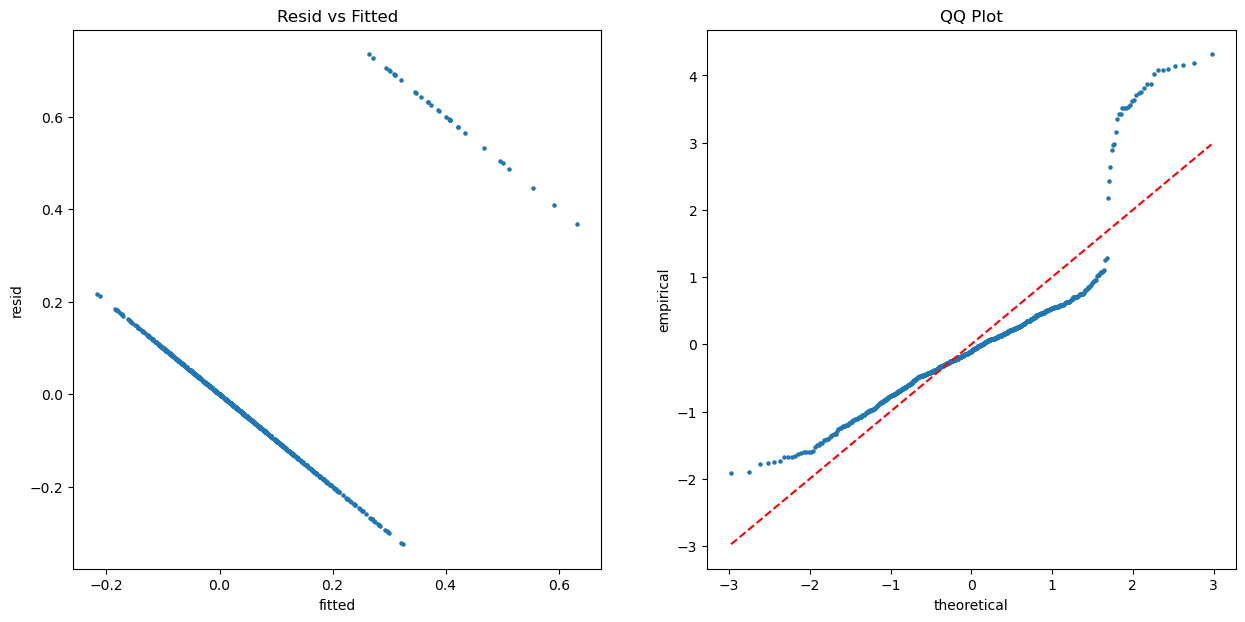

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].scatter(final_model.fittedvalues, final_model.resid, s=5)
ax[0].set_title("Resid vs Fitted")
ax[0].set_xlabel('fitted')
ax[0].set_ylabel('resid')

plot_against_theo(final_model.resid, norm, ax=ax[1])

This model is incorrect in the sense that HIS can only be $0$ or $1$, but the fitted values can be any real number at all.

We can see patterns in the diagnostic plots. Linear regression should not be used mainly because HIS is binary. Logistic regression is a good alternative.

## 2. Logistic Regression

### 2.1 Theory

We define a parameter 
\begin{equation*}	
	\pi_i=\mathbb{P}(Y_i=1|x_i),
\end{equation*}		

which is interpreted as the probability of $Y_i=1$ (probability of "success") given $x_i$. A crucial assumption in the logistic regression model is:
\begin{equation*}
	\ln\left(\frac{\pi_i}{1-\pi_i} \right) =\beta_0 + \beta_1 x_{i1}+ \ldots +  \beta_p x_{ip} = x_i^\top \beta, 						
\end{equation*}

where $x_i=(1,x_{i1},\dots,x_{ip})$ and $\beta=(\beta_0,\dots,\beta_p)$. 

\
The left hand side of the equation is the <b>log-odd ratio</b> of probability of success. Equivalently, it can be rewritten as
\begin{equation*}
	\pi_i=   \frac{\exp(x_i^\top \beta)}{1+\exp(x_i^\top \beta)},
\end{equation*}

which is called the <b>logit</b> transformation of $x_i^\top\beta$. Obviously, $\pi_i$ always lies between 0 and 1 and this is consistent with the interpretation as a probability of success.

\
To summarize, the logistic regression model is:
\begin{equation*}
	{\rm logit}(\pi) := \ln \left(\frac{\pi}{1 - \pi}\right) = \sum_{j=1}^p \beta_j x_j \, , 
\end{equation*}
where $\pi$ is the probability of "success" (here, the probability of being a blue chip). Or equivalently:

\begin{equation*}
	\pi_i = \frac{\exp \left(\sum_{j=1}^p \beta_j x_{ij}\right)}{1 + \exp \left(\sum_{j=1}^p \beta_j x_{ij}\right)} \, .
\end{equation*}

### 2.2 Implementation

In [29]:
model = sm.Logit(y, X).fit(method='bfgs', maxiter=1000)
model.summary()

Optimization terminated successfully.
         Current function value: 0.021720
         Iterations: 74
         Function evaluations: 88
         Gradient evaluations: 88


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    HSI   No. Observations:                  680
Model:                          Logit   Df Residuals:                      673
Method:                           MLE   Df Model:                            6
Date:                Sun, 19 Oct 2025   Pseudo R-squ.:                  0.8855
Time:                        23:10:06   Log-Likelihood:                -14.769
converged:                       True   LL-Null:                       -129.04
Covariance Type:            nonrobust   LLR p-value:                 1.570e-46
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -55.5007     16.159     -3.435      0.001     -87.173     -23.829
EY             1.1060      1.662      0.666      0.506      -2.151       4.363
CFTP          -1.3130      0.501     -2.622      0.009      -2.295      -0.332
ln_MV          5.8919      1.724      3.417      0.001       2.512       9.272
DY            -0.1599      0.212     -0.753      0.452      -0.576       0.257
BTME           0.1403      0.065      2.175      0.030       0.014       0.267
DTE           -0.1085      0.278     -0.391      0.696      -0.653       0.436
==============================================================================

Possibly complete quasi-separation: A fraction 0.87 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

I used ```bfgs``` because sometimes ```const``` makes our feature matrix "explode", i.e. becoming singular.

In [31]:
pred = model.predict(X) > 0.5
confusion_matrix = y.groupby([pred, y]).count().unstack()
confusion_matrix

HSI,0,1
False,646,3
True,2,29


In [32]:
X_optimized, final_model = backward_elimination(sm.Logit, y, X, fit_kwargs={'method': 'bfgs', 'maxiter': 1000})

Optimization terminated successfully.
         Current function value: 0.021720
         Iterations: 74
         Function evaluations: 88
         Gradient evaluations: 88
                           Logit Regression Results                           
Dep. Variable:                    HSI   No. Observations:                  680
Model:                          Logit   Df Residuals:                      673
Method:                           MLE   Df Model:                            6
Date:                Sun, 19 Oct 2025   Pseudo R-squ.:                  0.8855
Time:                        23:10:06   Log-Likelihood:                -14.769
converged:                       True   LL-Null:                       -129.04
Covariance Type:            nonrobust   LLR p-value:                 1.570e-46
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -55.5007     16.159     -

In [33]:
pred = final_model.predict(X_optimized) > 0.5
confusion_matrix = y.groupby([pred, y]).count().unstack()
confusion_matrix

HSI,0,1
False,646,4
True,2,28


It is expected that in the training dataset, the performance of our 'optimized' model may not be better than the full model.

That is simply because there are more degree of freedoms in the full model to overfit our data.

Therefore, we need the concept of <b>model validation</b>.

## 3. Model Evaluation

### 3.1 Training and Testing Datasets

In data mining, the number of samples can often be huge, so that we can split the whole dataset into two exclusive parts: training and testing datasets.

The training dataset is used to build the statistical model, while the testing dataset is used to assess the accuracy and the prediction power of the model. 

It can be easily done with ```train_test_split()``` in ```sklearn.model_selection```.

### 3.2 Lift Chart

The fitted value in the logistic regression output gives the probability of success of $\mathbb{P}(Y=1|x)$. 

Now if you sort the variable $Y$ according to the decreasing order of the "success probability" and assign the corresponding rankings to them, 

we would expect that most of the records with $Y=1$ will appear on the top of the list. 

We can actually compute the cumulative percentage of $Y=1$ and plot them against the ranking.

### 3.3 Confusion Matrix

When measuring the accuracy of a classification model, the overall accuracy computed from the classification table is not a too robust measure and can be misleading.

In [43]:
confusion_matrix = pd.DataFrame({'Disease': ['TP', 'FN', 'TP+FN'],
                               'No Disease': ['FP', 'TN', 'FP+TN'],
                               'Row Sum': ['TP+FP', 'FN+TN', 'Total']},
                              index=['Positive', 'Negative', 'Column Sum'])
confusion_matrix = confusion_matrix.rename_axis('Test').rename_axis('Truth', axis=1)
confusion_matrix

Truth,Disease,No Disease,Row Sum
Test,,,
Positive,TP,FP,TP+FP
Negative,FN,TN,FN+TN
Column Sum,TP+FN,FP+TN,Total


#### 3.3.1 Performance Measures

The precision, recall (TPR), FPR and $F_1$ score of a medical test are defined as follows.

$$\text{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}} $$ is the  correct percentage among positive results;

$$ \text{Recall (TPR)} = \frac{\text{TP}}{\text{TP}+\text{FN}}$$ is the proportion of observations being correctly classified as positive among all positive observations;
%$$\text{TPR} = \frac{\text{TP}}{\text{TP}+\text{FN}}$$ is the proportion of observations being correctly classified as positive among all positive observations;

$$\text{FPR} = \frac{\text{FP}}{\text{TN}+\text{FP}}$$ is defined as the proportion of observations that are incorrectly classified as positive among all negative observations;

$$F_1=\frac{\displaystyle 2}{\displaystyle 1/\text{Precision} +1/\text{Recall}}=\frac{\displaystyle 2 \times \text{Precision} \times \text{Recall}}{\displaystyle \text{Precision} + \text{Recall}}$$ 

Or more generally,
$$F_{\beta}=(1+\beta^2)\frac{\text{Precision} \times \text{Recall}}{\displaystyle \beta^2 \times \text{Precision} + \text{Recall}}$$ 
is the harmonic mean of precision and recall, and maximizing the F1 score implies simultaneously maximizing both precision and recall.

\
<b><u>Question</u></b> 

Why do we have metrics mentioned above? In which situation are they our first prioity to consider?